# Artificial Neural Networks

## Classification

### Data

We import the usual function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We set the numpy random seed and the random seed to a specific number, so every run will have the same result

In [2]:
import random
random.seed(42)
np.random.seed(42)

We create a data set of 400 point in 2d, with 4 classes: `0, 1, 2, 3`

In [3]:
import math
N = 400
NC = 100
X = np.array([(np.cos(math.pi + 1*(i/NC)) - i/(NC*10) + (np.random.rand()*0.1) + 0.16*math.floor(i/NC),
               np.sin(math.pi + -2*(i/NC)) + i/(NC*10) + (np.random.rand()*0.6)) for i in range(N)])
Y = np.array([math.floor(i/NC) for i in range(N)])
X.shape

(400, 2)

Let's see what our data looks like

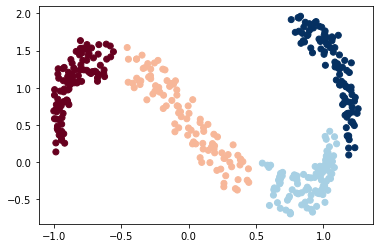

In [4]:
plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.RdBu)

As we saw in the previous notebook, we will use the `train_test_split` function from sklearn to split our data into training and testing set

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=42)

In [6]:
print(x_train.shape)
print(x_test.shape)

(300, 2)
(100, 2)


### Scikit-Learn

We start by using sklearn and the `MLPClassifier`, a multi-perceptron classifier

In [7]:
# we import the classifier from sklearn
from sklearn.neural_network import MLPClassifier
# we create the classifier
# random_state fix the randomness of the classifier itself
# max_iter is here in case the classifier take too much time for training.
# it limits the training to 1000 iteration
ann = MLPClassifier(random_state=42, max_iter=1000)

# we fit/train our neural networks with the training data
ann.fit(x_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

We can see a few of it's attributes

In [8]:
print(ann.activation, ann.learning_rate, ann.hidden_layer_sizes)

relu constant (100,)


In [9]:
# we use predict to get the prediction the model does about some data
# it's done without giving it the label
predicted = ann.predict(x_test)

As we saw during the previous notebook, we can plot confusion matrix with sklearn. 

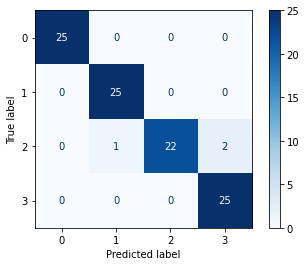

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted, labels=[0,1,2,3])
c = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
c.plot(cmap=plt.cm.Blues)

Here we dome some visualisation: we will create a grid of the size of the space, and use out model to predict the value of each point of the grid, and then displayu it, allowing us to colour the space.
We also display our points

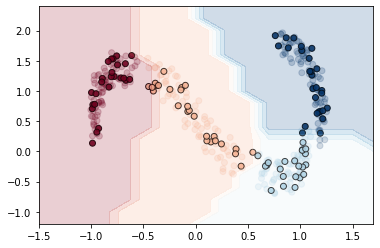

In [11]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.RdBu, alpha=0.2)
plt.scatter(x_test[:, 0], x_test[:, 1], c=predicted, cmap=plt.cm.RdBu, alpha=0.9,
            edgecolors='k')
Z = ann.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.2)

### PyTorch

We will now see how to use PyTorch, a Machine Learning library used to create neural networks of all sorts.

Since we create our neural networks "from scratch" and train it manually, if we want similar results every time, we should we set the seed every time before training

In [12]:
# PyTorch is named torch
import torch
# we set the random for numpy, torch and the normal random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

PyTorch allow us to use the GPU instead of the CPU for computation. Neural Networks are specially designed now to take full advantage of the power of GPU.

In [13]:
# we set device to either cuda:0 (gpu) or cpu. PyTorch will use the gpu is possible
# otherwise it will fall back to cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# PyTorch use tensor instead of numpy array. It is a derived type from the array we
# usually use, just like the Pandas Dataframe.
# Those tensor can be "sent" to the gpu with the function to
# however, if device value is cpu, torch won't do anything and will just use the cpu
# as usual
x_train_t = torch.from_numpy(x_train).to(device)
x_test_t= torch.from_numpy(x_test).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
y_test_t = torch.from_numpy(y_test)

Contrary to Sklearn where the model constructor have a lot of pre-defined argument, we usually choose everything ourselves when building a Neural Networks in PyTorch. It recquires a bit more knowledge.

Here we create a simple neural network with 1 hidden layer.

In [14]:
# we define the size of the input, here it will be 2, because our point are in 2d
input_size = x_train_t.shape[1]
# we defined how much neuron we want in the hidden layer
hidden_layer_size = 100
# we define the output size. Here the number of classes we have
output_size = 4
# we create the model. We use a simple sequential model
# It's the common neural networks
model = torch.nn.Sequential(
    # we define a layer, with the input and output size
    # A layer in PyTorch is a layer of weight
    # here it is 2 -> 100
    # the layer will do the weight multiplication and add the bias addition
    torch.nn.Linear(input_size, hidden_layer_size, bias=True),
    # we put a non linearity after our first layer of weight. It is the activation
    # function on the hidden layer
    torch.nn.ReLU(),
    # we now define a layer of weight between the hidden layer and the output
    # it is 100 -> 4
    torch.nn.Linear(hidden_layer_size, output_size, bias=True)
)
# the model looks like this
# (input) 2 values -> linear 1 -> 100 values -> relu -> linear 2 -> 4 values (output)


# we send our model to our device (gpu or cpu)
model.double().to(device)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=4, bias=True)
)

We define some more hyper parameter: the loss, the learning rate and the optimizer

In [15]:
# we define our loss function. For classification we use the Cross Entropy
criterion = torch.nn.CrossEntropyLoss()
# we define a learning rate
learning_rate = 1e-3
# we create an optimiser. Adam is a choice, there's tons of other
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

We will train our model. We do it ourselves in PyTorch. We have to choose make the loop for training, and to do all the steps of the training if the neural networks

In [16]:
# we do 1000 epochs
for i in range(1000):
    # step 1: forward pass
    y_pred_t = model(x_train_t)
    # step 2: compute loss
    loss = criterion(y_pred_t, y_train_t)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (i, loss.item()), end='\r')
    # PyTorch step: we have to empty the gradient before recomputing it
    optimizer.zero_grad()
    # step 3: backward pass
    loss.backward()
    # step 4: update weight
    optimizer.step()

Let's see how good is our model

In [17]:
# we use our model to predict the output of the test set
# we have to send back this results to the cpu
# then we take the maximum of the 4 output (to take the most likely prediction)
# and we chooses it's indices
predicted = model(x_test_t).cpu().max(1).indices

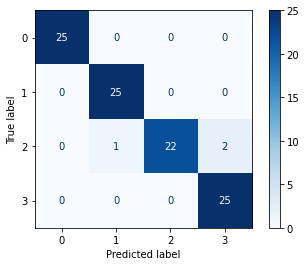

In [18]:
cm = confusion_matrix(y_test, predicted, labels=[0,1,2,3])
c = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
c.plot(cmap=plt.cm.Blues)

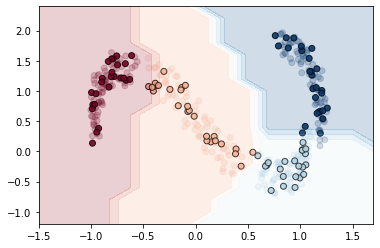

In [19]:
# we have to send our data and the model to the cpu so we can access them
model.cpu()
x_train_t = x_train_t.cpu()
x_test_t = x_test_t.cpu()
y_train_t = y_train_t.cpu()

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))
plt.scatter(x_train_t[:, 0], x_train_t[:, 1], c=y_train_t, cmap=plt.cm.RdBu, alpha=0.2)
plt.scatter(x_test_t[:, 0], x_test_t[:, 1], c=predicted, cmap=plt.cm.RdBu, alpha=0.9,
            edgecolors='k')
# we use no grad because we don't care about computing the gradient
# it makes the computation faster as it avoid some unecessary computation
with torch.no_grad():
    data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).double()
    Z = model(data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.2)

## Regression

We will now see how to do regression

### Data

First, we define a function to approximate, and we plot it.

We made the function using torch functions so we don't have to rewrite it later, as pytorch can have problems using normal numpy stuff, while numpy can works with PyTorch tensor easily.

We will generate 1000 datapoints, from -1 to 1, and will computer their value through the function. We will use those points to approximate the function

torch.Size([1000, 1]) torch.Size([1000, 1])


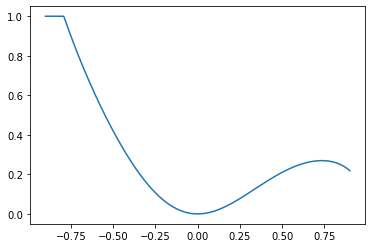

In [20]:
def f_target(x):
    return torch.max(torch.min((torch.acos(x) * x.pow(2) / (1+torch.tanh(x**2))),
                               torch.scalar_tensor(1)),
                     torch.scalar_tensor(0))
X = torch.unsqueeze(torch.linspace(-0.9, 0.9, 1000), dim=1) 
y = f_target(X)
print(X.shape, y.shape)
plt.plot(X, y)

### Scikit-Learn

As well as for the DecisionTree, which had a Classifier and a regressor objects, we have both type of MLP objects.

In [21]:
# we import the classifier from sklearn
from sklearn.neural_network import MLPRegressor
# we create the classifier
# random_state fix the randomness of the classifier itself
# max_iter is here in case the classifier take too much time for training.
# it limits the training to 1000 iteration
ann = MLPRegressor(max_iter=1000, hidden_layer_sizes=5000)

# we fit/train our neural networks with the training data
ann.fit(X, y.reshape(-1))

MLPRegressor(hidden_layer_sizes=5000, max_iter=1000)

In [22]:
print(ann.activation, ann.learning_rate, ann.hidden_layer_sizes)

relu constant 5000


We will use our entire data, as we are trying to approximate the results

In [23]:
predicted = ann.predict(X)

(-1.0, 1.0, 0.0, 1.0)

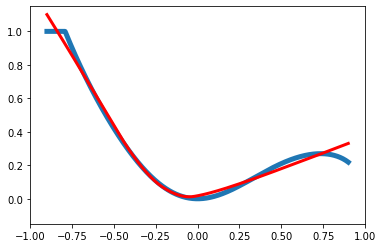

In [24]:
plt.plot(X, y, lw=5)
plt.plot(X, predicted, c='red', lw=3)
plt.axis('equal')
plt.axis(np.array((-1, 1, 0, 1)))

### PyTorch

PyTorch works exactly the same for regression or classification, since we are the one choosing the different hyperparameters such as the loss function, we can choose to make our neural networks do everything we want.

In [25]:
# we reset the random seed here, so we can retrain our neural networks easily
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

We create a sequential layer again. We do it in the same way as we do for the classification, only changing the input and output size.

In [26]:
input_size = 1
hidden_layer_size = 100
output_size = 1
model = torch.nn.Sequential(
    # 1 -> 100
    torch.nn.Linear(input_size, hidden_layer_size),
    # relu on hidden layer
    torch.nn.ReLU(),
    # 100 -> 1
    torch.nn.Linear(hidden_layer_size, output_size)
)
# the model looks like this
# (input) 1 value -> linear 1 -> 100 values -> relu -> linear 2 -> 1 value (output)


model.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

Since we do regression we use the mean square error as the loss function.

In [27]:
criterion = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Once again we do the training loop ourself

In [28]:
# we send our data to the gpu
X = X.to(device)
y = y.to(device)
# we do 1000 epochs
for i in range(1000):
    # step 1: forward pass
    y_pred = model(X)
    # step 2: compute loss
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (i, loss.item()), end='\r')
    # PyTorch step: we have to empty the gradient before recomputing it
    optimizer.zero_grad()
    # step 3: backward pass
    loss.backward()
    # step 4: update weight
    optimizer.step()

We comnpare our approximation with the original function

(-1.0, 1.0, 0.0, 1.0)

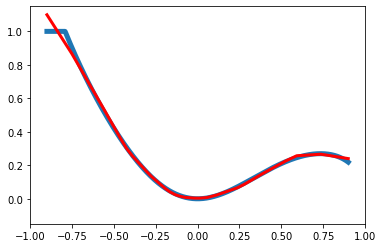

In [29]:
plt.plot(X.cpu().detach(), y.cpu().detach(), lw=5)
plt.plot(X.cpu().detach(), y_pred.cpu().detach(), c='red', lw=3)
plt.axis('equal')
plt.axis(np.array((-1, 1, 0, 1)))